
# Predicció de pluja de l'endemà

Aquest notebook conté la implementació d'un estudi realitzat per **Marta Nadal Par** i **Jaume Mora Ladària** sobre la predicció de pluja utilitzant regressió logística i perceptró multicapa. El treball ha estat desenvolupat en el marc de l'assignatura de Xarxes Neuronals i Deep Learning del Grau en Intel·ligència Artificial.

Les metodologies aplicades i els resultats obtinguts són presentats detalladament a continuació, proporcionant una visió completa de l'aplicació de tècniques avançades d'aprenentatge automàtic en el tractament i anàlisi de dades meteorològiques.


In [ ]:
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import datasets
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import KNNImputer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Càrrega de les dades

In [ ]:
# Data path Jaume:
data_path = '/content/drive/MyDrive/Datasets/'
#data_path = '/Users/jaumemil/Desktop/IA/2n/XNDL/Practica1/'

In [ ]:
# Data path Marta:
# data_path = '/content/drive/MyDrive/XNDL_parctica/'

#data_path: '/Users/Usuario/Desktop/uni/Q4/XNDL'

In [ ]:
rain_data = pd.read_csv(os.path.join(data_path, "rain_data.csv"), header=0, delimiter=',')
rain_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
1,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
2,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
3,2008-12-11,Albury,13.4,30.4,0.0,NaN,NaN,N,30.0,SSE,...,48.0,22.0,1011.8,1008.7,NaN,NaN,20.4,28.8,No,Yes
4,2008-12-12,Albury,15.9,21.7,2.2,NaN,NaN,NNE,31.0,NE,...,89.0,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0,Yes,Yes


## SECCIÓ 1. Anàlisi exploratòria de les dades (EDA)

### 1.1. Estudi estadístic de les variables utilitzant gràfics:

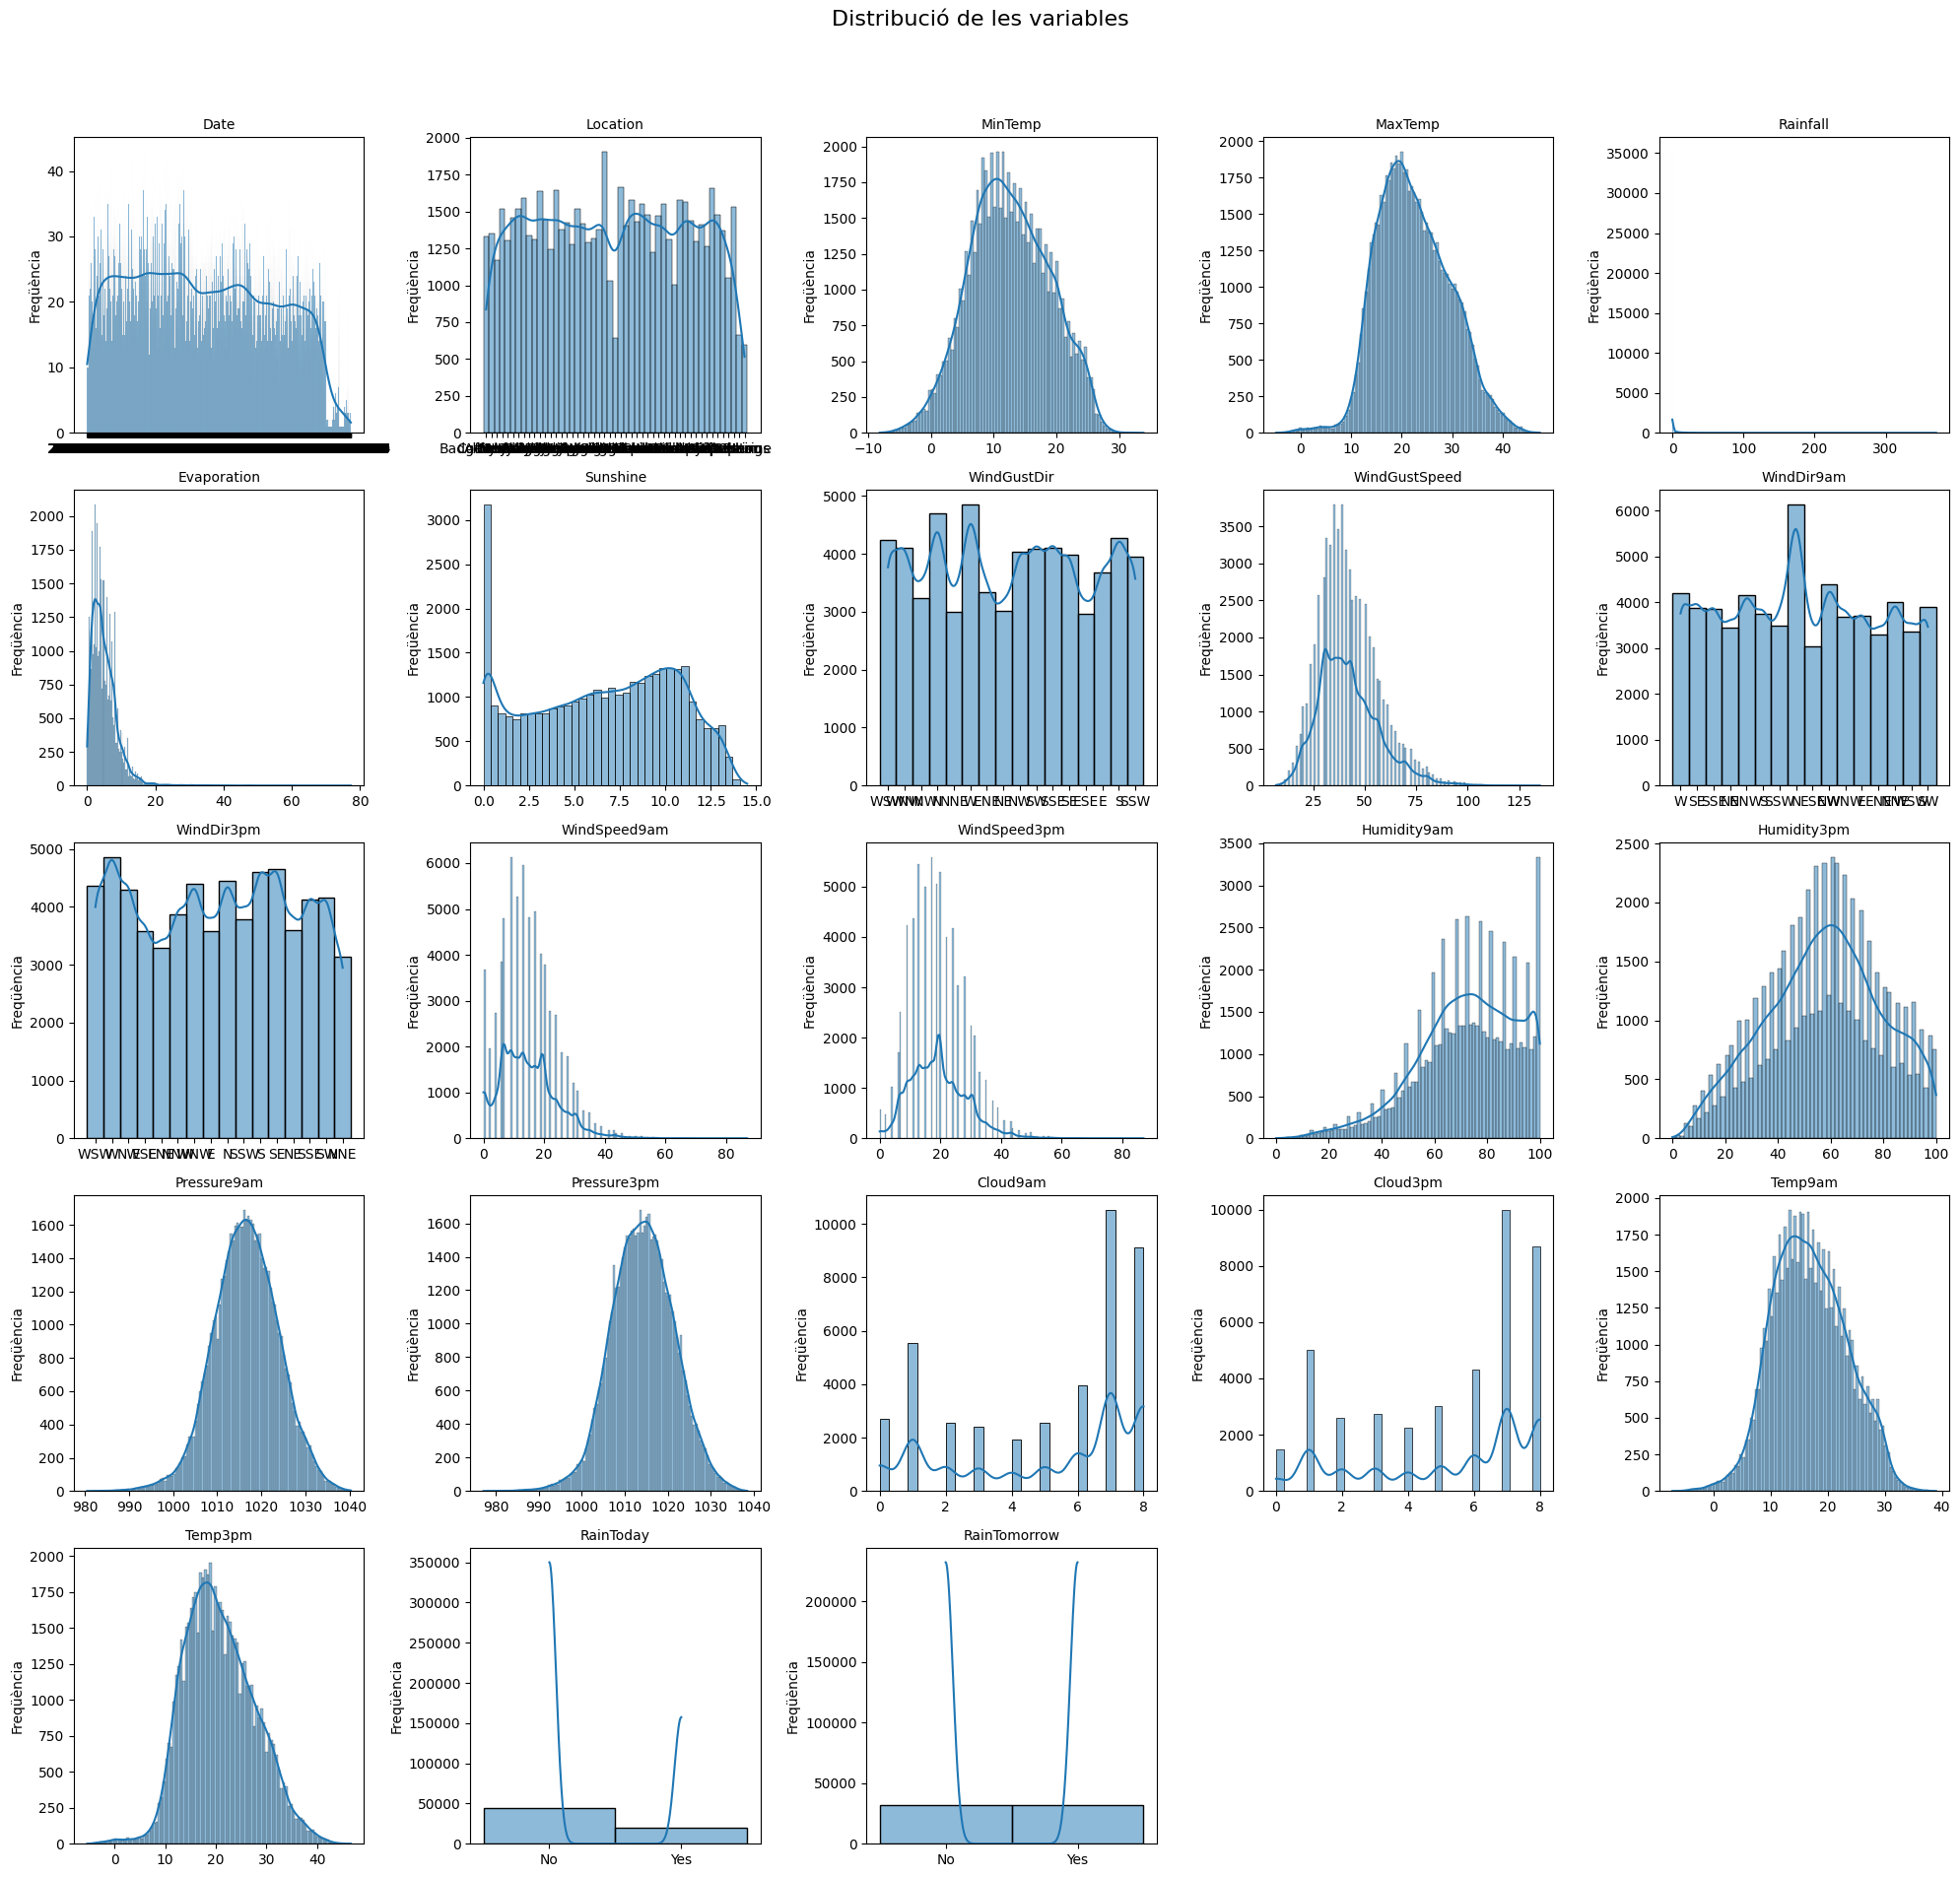

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 5, figsize=(20, 20))
fig.suptitle('Distribució de les variables', fontsize=16)

for ax in axes.flatten():
    ax.set_visible(False)

for ax, var in zip(axes.flatten(), rain_data.columns):
    ax.set_visible(True)
    sns.histplot(data=rain_data, x=var, kde=True, ax=ax)
    ax.set_title(var, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('Freqüència')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 1.2. Identificació dels missings per variable:


In [ ]:
missing_values = rain_data.isnull().sum()
print(missing_values)

Date                 0
Location             0
MinTemp           1157
MaxTemp           1081
Rainfall          2750
Evaporation      29430
Sunshine         32190
WindGustDir       5487
WindGustSpeed     5445
WindDir9am        4751
WindDir3pm        2288
WindSpeed9am      1050
WindSpeed3pm      1693
Humidity9am       1764
Humidity3pm       2633
Pressure9am       7271
Pressure3pm       7260
Cloud9am         25718
Cloud3pm         26950
Temp9am           1332
Temp3pm           2210
RainToday         2750
RainTomorrow      3267
dtype: int64


### 1.3. Estudi de la correlació entre variables numèriques:

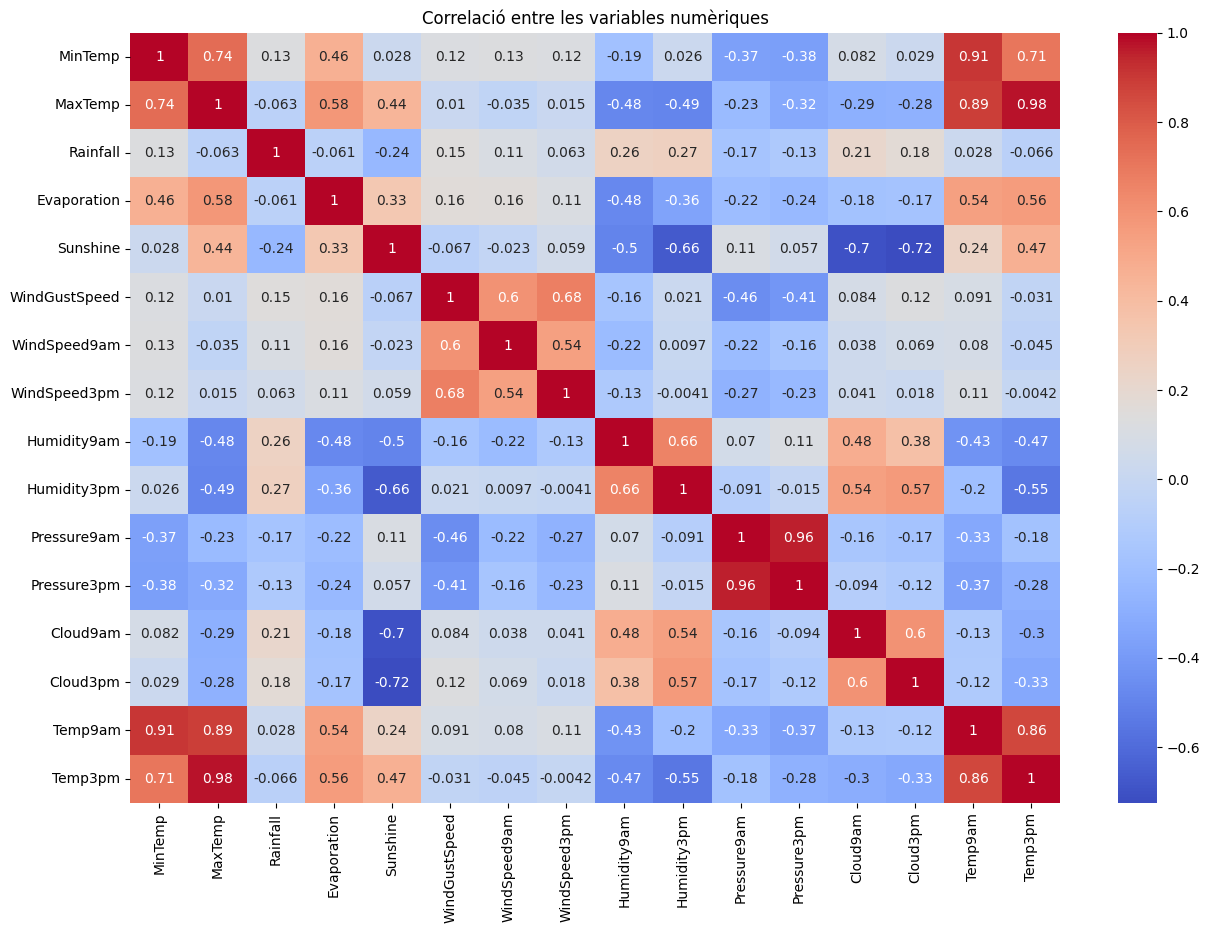

In [ ]:
# Comencem definint quines són les nostres variables numèriques
numeric_variables = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am','Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

rd_num_variables = rain_data[numeric_variables]
plt.figure(figsize=(15, 10))
sns.heatmap(rd_num_variables.corr(), annot=True, cmap='coolwarm')
plt.title('Correlació entre les variables numèriques')
plt.show()

## SECCIÓ 2. Preprocessament de les dades

### 2.1. Conversió de la variable Date en Season (estació de l'any com Primavera, Estiu, Tardor o Hivern):

La variable date la convertim a una entre 0 i 1. Si és hivern serà 0, si és primavera 0,33, si és estiu 0,66 i si és tardor 1.

In [ ]:
rain_data['Date'] = pd.to_datetime(rain_data['Date'])
rain_data['Month'] = rain_data['Date'].dt.month
rain_data['Season'] = rain_data['Month'].apply(lambda x: 0 if x in [12, 1, 2] else (0.33 if x in [3, 4, 5] else (0.66 if x in [6, 7, 8] else 1)))
rain_data = rain_data.drop(['Date', 'Month'], axis=1)

### 2.2. Tractament de les variables RainToday i RainTomorrow:

En aquest cas hem optat per eliminar totes les files en les quals RainTomorrow tenia missings ja que hem considerat que, al tenir tantes dades, no volíem haver d'imputar els missings de la que serà la variable objectiu. A més a més, hem convertit les dades 'Yes'/'No' a format binari.

In [ ]:
# Eliminem els missings de RainTomorrow al ser la variable objectiu:
rain_data = rain_data.dropna(subset=['RainTomorrow'])

# Modifiquem les variables RainToday i RainTomorrow:
rain_data['RainToday'] = rain_data['RainToday'].map({'Yes': 1, 'No': 0})
rain_data['RainTomorrow'] = rain_data['RainTomorrow'].map({'Yes': 1, 'No': 0})
print(rain_data[['RainToday', 'RainTomorrow']].head())


   RainToday  RainTomorrow
0        0.0             0
1        0.0             0
2        0.0             1
3        0.0             1
4        1.0             1


### 2.3. Generalització de la variable Location:


Aquí hem modificat la variable Location de manera que hem agrupat les ciutats en estats d'Austràlia. Així hem passat de tenir 49 ciutats a 8 estats i hem pogut reduir el cost del OneHotEncoding que hem aplicat després.

In [ ]:
# Creem un diccionari amb els estats i les seves ciutats
state_city = {
    'NSW': ['Sydney', 'Wollongong', 'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond', 'SydneyAirport', 'Williamtown', 'WaggaWagga', 'Wollongong'],
    'NT': ['Darwin', 'Katherine', 'Uluru'],
    'QL': ['Brisbane', 'Cairns', 'GoldCoast', 'Townsville'],
    'SA': ['Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera'],
    'TA': ['Hobart', 'Launceston'],
    'VI': ['Melbourne', 'Ballarat', 'Bendigo', 'Sale', 'MelbourneAirport', 'Mildura'],
    'WA': ['Perth', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport'],
    'OT': ['Cobar', 'CoffsHarbour', 'Moree', 'NorfolkIsland', 'Richmond', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong']
}

# Funció que retorna l'estat segons la ciutat:
def get_state(location):
    for state, cities in state_city.items():
        if location in cities:
            return state

rain_data['State'] = rain_data['Location'].apply(get_state)
rain_data = rain_data.drop('Location', axis=1)


In [ ]:
# OneHotEncoding de la variable State:
rain_data = pd.get_dummies(rain_data, columns=['State'], drop_first=True)
rain_data.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,RainToday,RainTomorrow,Season,State_NT,State_OT,State_QL,State_SA,State_TA,State_VI,State_WA
0,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,...,0.0,0,0.0,False,False,False,False,False,False,False
1,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,19.0,...,0.0,0,0.0,False,False,False,False,False,False,False
2,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,7.0,...,0.0,1,0.0,False,False,False,False,False,False,False
3,13.4,30.4,0.0,NaN,NaN,N,30.0,SSE,ESE,17.0,...,0.0,1,0.0,False,False,False,False,False,False,False
4,15.9,21.7,2.2,NaN,NaN,NNE,31.0,NE,ENE,15.0,...,1.0,1,0.0,False,False,False,False,False,False,False


### 2.4. Tractament de la variables amb direccions del vent:


Separem les variables categòriques WindGustDir, WindDir9am i WindDir3pm en una variable Nord-Sud i una variable Est-Oest per a cada una d'elles


In [ ]:
# Creem una funció que ens retorni la direcció Nord-Sud
def get_north_south(direction):
    if not (pd.isna(direction)):
        if 'N' in direction:
            return 1
        elif 'S' in direction:
            return 0
        else:
            return 0.5

# Creem una funció que ens retorni la direcció Est-Oest
def get_east_west(direction):
    if not (pd.isna(direction)):
        if 'E' in direction:
            return 1
        elif 'W' in direction:
            return 0
        else:
            return 0.5

rain_data['WindGustDir_NS'] = rain_data['WindGustDir'].apply(get_north_south)
rain_data['WindGustDir_EW'] = rain_data['WindGustDir'].apply(get_east_west)
rain_data = rain_data.drop('WindGustDir', axis=1)

rain_data['WindDir9am_NS'] = rain_data['WindDir9am'].apply(get_north_south)
rain_data['WindDir9am_EW'] = rain_data['WindDir9am'].apply(get_east_west)
rain_data = rain_data.drop('WindDir9am', axis=1)

rain_data['WindDir3pm_NS'] = rain_data['WindDir3pm'].apply(get_north_south)
rain_data['WindDir3pm_EW'] = rain_data['WindDir3pm'].apply(get_east_west)
rain_data = rain_data.drop('WindDir3pm', axis=1)

rain_data.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,State_SA,State_TA,State_VI,State_WA,WindGustDir_NS,WindGustDir_EW,WindDir9am_NS,WindDir9am_EW,WindDir3pm_NS,WindDir3pm_EW
0,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,...,False,False,False,False,0.0,0.0,0.5,0.0,0.0,0.0
1,14.6,29.7,0.2,NaN,NaN,56.0,19.0,24.0,55.0,23.0,...,False,False,False,False,1.0,0.0,0.5,0.0,0.5,0.0
2,9.7,31.9,0.0,NaN,NaN,80.0,7.0,28.0,42.0,9.0,...,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0
3,13.4,30.4,0.0,NaN,NaN,30.0,17.0,6.0,48.0,22.0,...,False,False,False,False,1.0,0.5,0.0,1.0,0.0,1.0
4,15.9,21.7,2.2,NaN,NaN,31.0,15.0,13.0,89.0,91.0,...,False,False,False,False,1.0,1.0,1.0,1.0,1.0,1.0


### 2.5. Eliminació de les variables amb més de 25000 missings:

Com que hem observat que algunes variables del nostre dataset, que consta de 60000 entrades, tenen més de 25000 valors mancants (que suposa la meitat de les dades), hem decidit eliminar aquestes variables.

In [ ]:
var_eliminar = ['Rainfall', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
rain_data = rain_data.drop(columns=var_eliminar)
print(rain_data.columns)

Index(['MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Season', 'State_NT',
       'State_OT', 'State_QL', 'State_SA', 'State_TA', 'State_VI', 'State_WA',
       'WindGustDir_NS', 'WindGustDir_EW', 'WindDir9am_NS', 'WindDir9am_EW',
       'WindDir3pm_NS', 'WindDir3pm_EW'],
      dtype='object')


### 2.6. Tractament d'outliers:

Primer mostrem com són les variables numèriques abans del tractament d'outliers per poder comparar després com han quedat.

In [ ]:
nv_after = ['MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm']

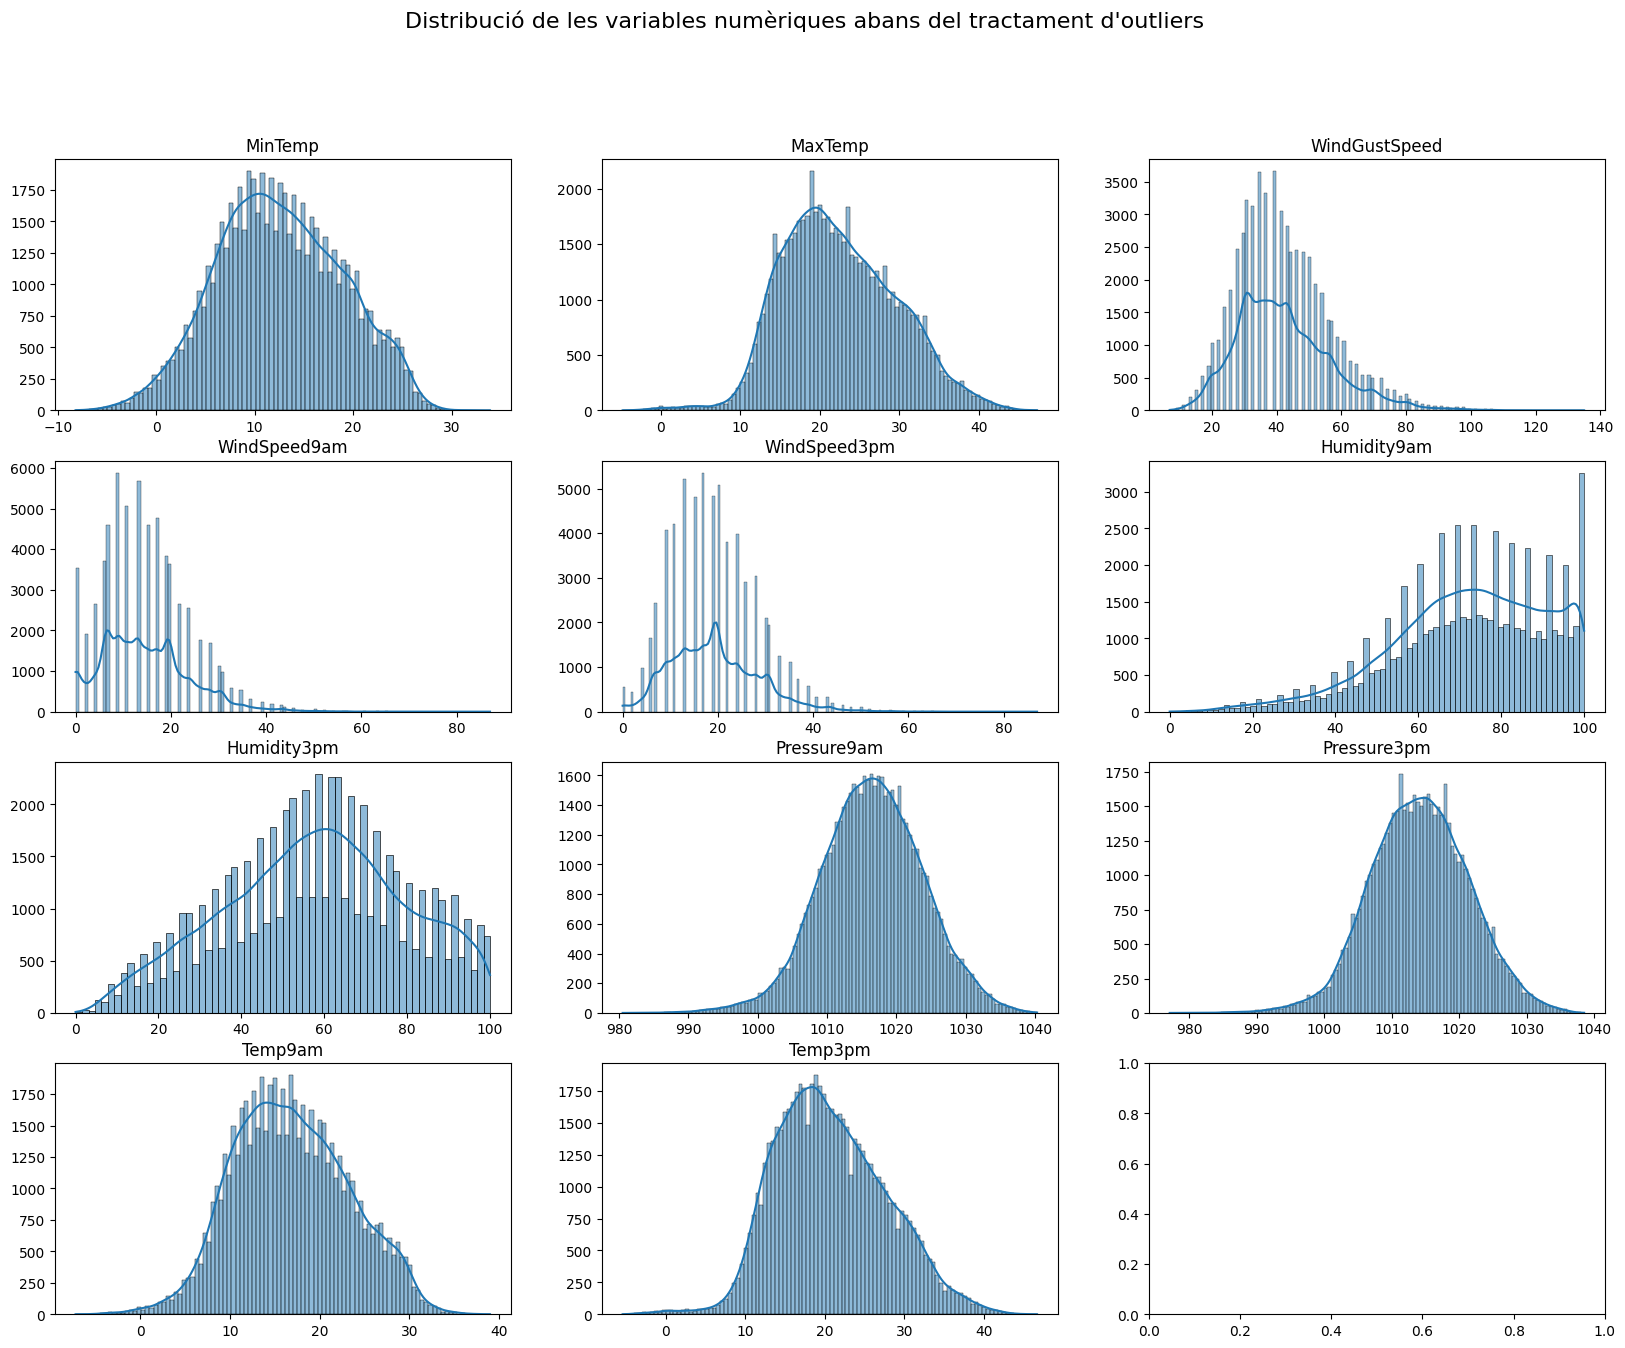

In [ ]:
# Creem una figura que tindrà 9 gràfics de distribució de les variables numèriques
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
fig.suptitle('Distribució de les variables numèriques abans del tractament d\'outliers', fontsize=16)


# Creem un for que em recorri les variables numèriques
for ax, var in zip(axes.flatten(), nv_after):
    sns.histplot(data=rain_data, x=var, kde=True, ax=ax)
    ax.set_title(var)
    ax.set_xlabel('')
    ax.set_ylabel('')


Identifiquem i eliminem els outliers de les variables numèriques.

In [ ]:
num_files_actuals = rain_data.shape[0]
Q1 = rain_data[nv_after].quantile(0.25)
Q3 = rain_data[nv_after].quantile(0.75)
IQR = Q3 - Q1

outliers = (rain_data[nv_after] < (Q1 - 1.5 * IQR)) | (rain_data[nv_after] > (Q3 + 1.5 * IQR))

print(outliers.sum())

# Esborrem els outliers
rain_data = rain_data[~outliers.any(axis=1)]
num_files_post = rain_data.shape[0]
print("Número de files esborrades: ", num_files_actuals - num_files_post)


MinTemp            40
MaxTemp           290
WindGustSpeed    1167
WindSpeed9am      786
WindSpeed3pm     1422
Humidity9am       722
Humidity3pm         0
Pressure9am       643
Pressure3pm       509
Temp9am           128
Temp3pm           373
dtype: int64
Número de files esborrades:  4175


Tornem a mostrar la distribució de totes les numèriques per veure com han quedat.

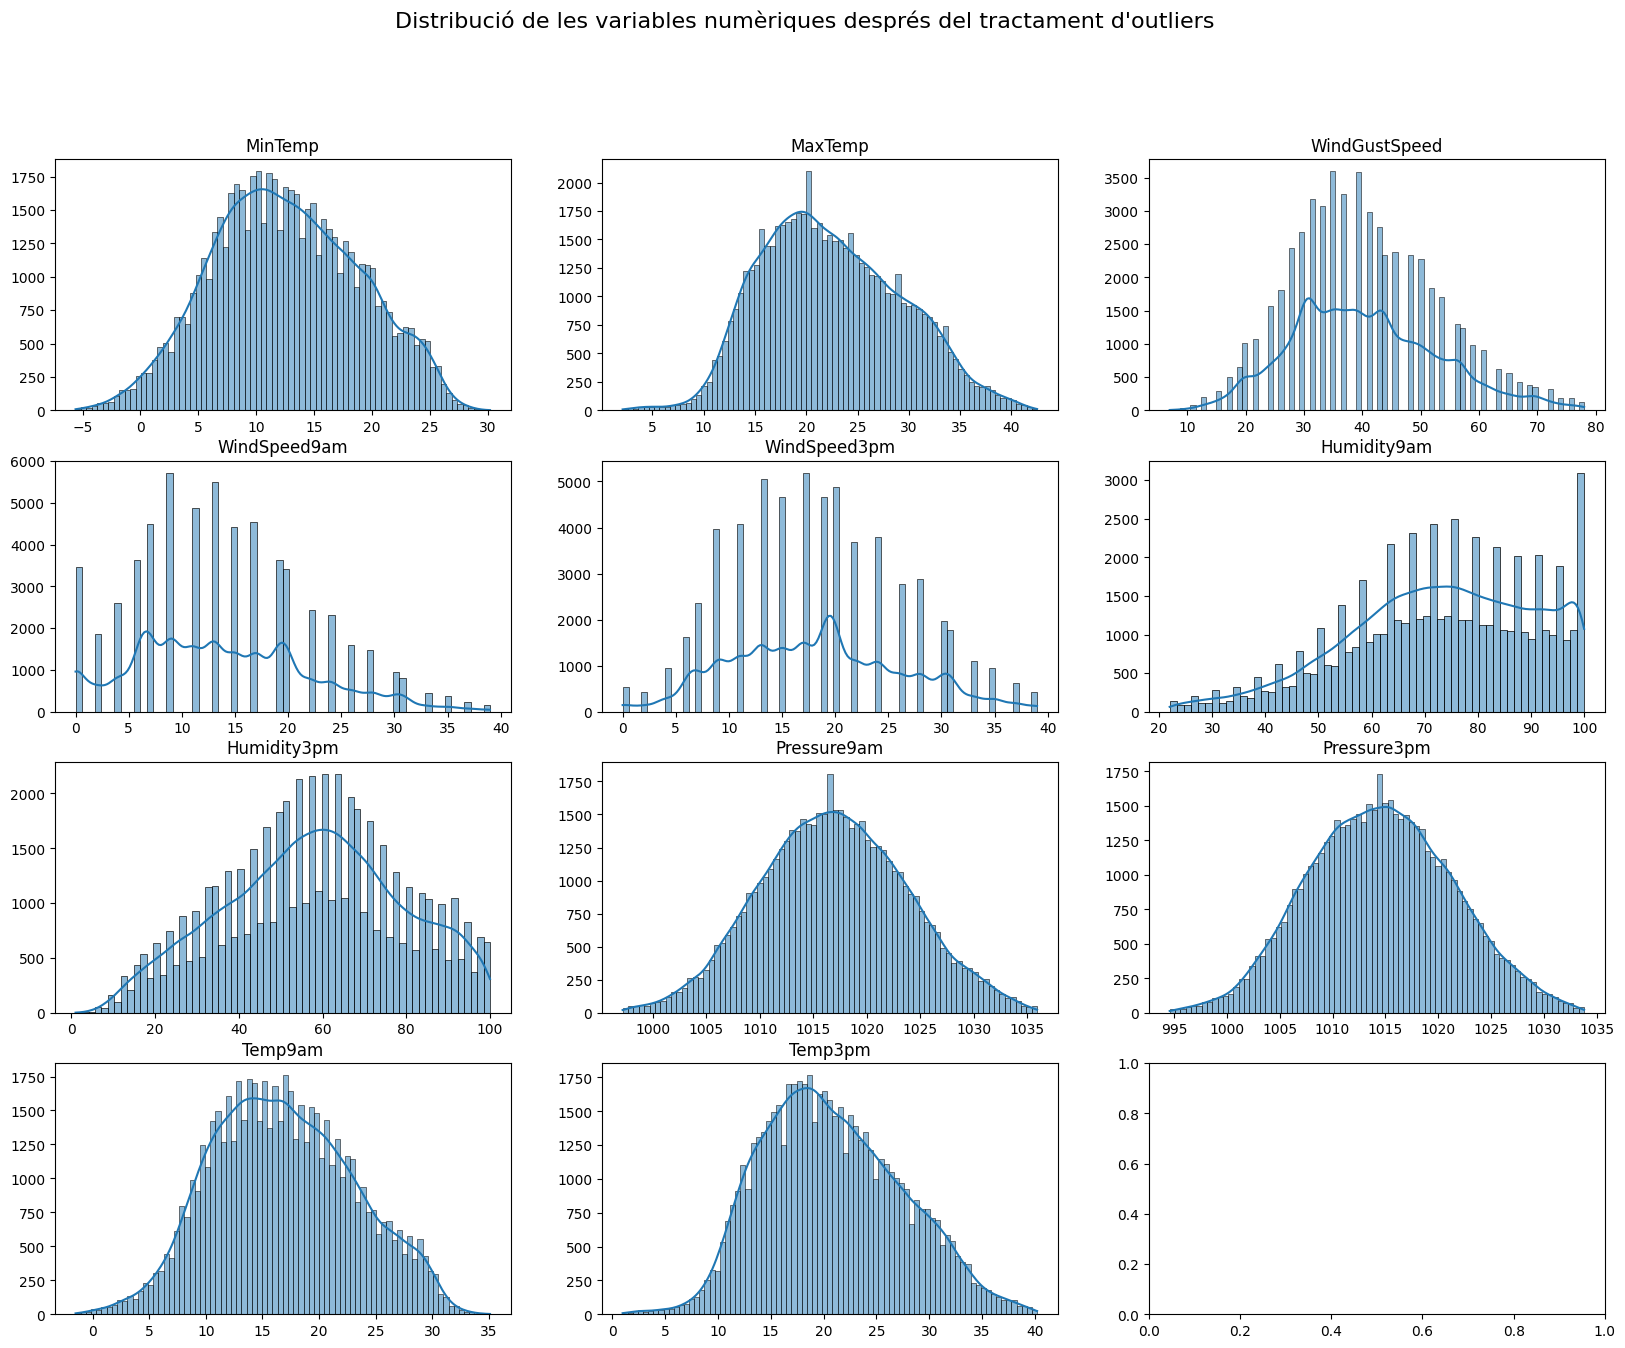

In [ ]:
# Creo una figura que tindrà 9 gràfics de distribució de les variables numèriques
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
fig.suptitle('Distribució de les variables numèriques després del tractament d\'outliers', fontsize=16)


# Creo un for que em recorri les variables numèriques
for ax, var in zip(axes.flatten(), nv_after):
    sns.histplot(data=rain_data, x=var, kde=True, ax=ax)
    ax.set_title(var)
    ax.set_xlabel('')
    ax.set_ylabel('')


## SECCIÓ 3. Remostreig

### 3.1. Partició train-test:

In [ ]:
X = rain_data.drop('RainTomorrow', axis=1)
y = rain_data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 3.2. Tractament de missings:

Comprovem quants missings hi ha a cada conjunt:

In [ ]:
print('Missings a X_train:', X_train.isnull().sum().sum())
print('Missings a X_test:', X_test.isnull().sum().sum())

Missings a X_train: 30249
Missings a X_test: 13135


Tractem els missings amb un KNNImputer:

In [ ]:
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Comprovem que ja no hi ha missings
print('Missings a X_train:', X_train_imputed.isnull().sum().sum())
print('Missings a X_test:', X_test_imputed.isnull().sum().sum())

Missings a X_train: 0
Missings a X_test: 0


### 3.3. Apliquem un MinMaxScaler a les dades:

Escalem amb un MinMaxScaler totes les dades entre 0 i 1.

In [ ]:
# # Ara podem aplicar MinMaxScaler
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_imputed)
X_test_normalized = scaler.transform(X_test_imputed)

# Convertim els arrays en dataframes
X_train = pd.DataFrame(X_train_normalized, columns=X_train_imputed.columns)
X_test = pd.DataFrame(X_test_normalized, columns=X_test_imputed.columns)

X_train.head()

,MinTemp,MaxTemp,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,...,State_SA,State_TA,State_VI,State_WA,WindGustDir_NS,WindGustDir_EW,WindDir9am_NS,WindDir9am_EW,WindDir3pm_NS,WindDir3pm_EW
0,0.382682,0.408416,0.366197,0.487179,0.282051,0.538462,0.535354,0.485788,0.556122,0.397790,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0
1,0.703911,0.663366,0.478873,0.435897,0.846154,0.346154,0.525253,0.514212,0.502551,0.770718,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2,0.508380,0.428218,0.394366,0.564103,0.487179,0.705128,0.515152,0.733850,0.742347,0.436464,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.804469,0.839109,0.295775,0.333333,0.282051,0.756410,0.535354,0.266150,0.239796,0.781768,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.645251,0.670792,1.000000,0.769231,0.615385,0.525641,0.343434,0.540052,0.420918,0.616022,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.5


## SECCIÓ 4. Model de regressió logística

### 4.1. GridSearchCV pels hiperparàmetres de la regressió logística:

Necessitarem fer GridSearchCV per a trobar els millors hiperparàmetres per fer una regressió logística per a predir RainTomorrow.

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Els millors hiperparàmetres per a la regressió logística són:', grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Els millors hiperparàmetres per a la regressió logística són: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


### 4.2. Entrenament i resultats del model:

Entrenem i avaluem el model de regressió logística, entrenant-lo amb els hiperparàmetres trobats. A més a més, utilitzem la validació creuada.

In [ ]:
log_reg = LogisticRegression(**grid_search.best_params_)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

results = cross_validate(log_reg, X_train, y_train, cv=5, scoring=scoring)

print("Mitjana de l'accuracy en validació creuada:", results['test_accuracy'].mean())
print("Mitjana de la precisió en validació creuada:", results['test_precision'].mean())
print("Mitjana del f1-score en validació creuada:", results['test_f1_score'].mean())

Mitjana de l'accuracy en validació creuada: 0.7750149862126844
Mitjana de la precisió en validació creuada: 0.7752834572330595
Mitjana del f1-score en validació creuada: 0.7748603436209505


## SECCIÓ 5. Perceptró Multicapa MLP

### 5.1. Definim una funció per a després poder treure les curves de cada model:

In [ ]:
def plot_curves(history):

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(train_loss) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(epochs, train_accuracy, 'g-', label='Training Accuracy')
  axes[1].plot(epochs, val_accuracy, 'orange', label='Validation Accuracy')
  axes[1].set_title('Training and Validation Accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()

  plt.show()



### 5.2 Model 1 de MLP:

El primer dels nostres models l'hem fet amb una capa amb 100 neurones:

Epoch 1/100
587/587 - 2s - loss: 1.1311 - accuracy: 0.5921 - val_loss: 0.6087 - val_accuracy: 0.6797 - 2s/epoch - 4ms/step
Epoch 2/100
587/587 - 2s - loss: 0.5809 - accuracy: 0.7126 - val_loss: 0.5554 - val_accuracy: 0.7286 - 2s/epoch - 3ms/step
Epoch 3/100
587/587 - 2s - loss: 0.5395 - accuracy: 0.7484 - val_loss: 0.5199 - val_accuracy: 0.7579 - 2s/epoch - 3ms/step
Epoch 4/100
587/587 - 2s - loss: 0.5454 - accuracy: 0.7457 - val_loss: 0.5304 - val_accuracy: 0.7454 - 2s/epoch - 3ms/step
Epoch 5/100
587/587 - 2s - loss: 0.5292 - accuracy: 0.7517 - val_loss: 0.5050 - val_accuracy: 0.7492 - 2s/epoch - 3ms/step
Epoch 6/100
587/587 - 2s - loss: 0.5310 - accuracy: 0.7469 - val_loss: 0.5191 - val_accuracy: 0.7514 - 2s/epoch - 3ms/step
Epoch 7/100
587/587 - 2s - loss: 0.5230 - accuracy: 0.7540 - val_loss: 0.5019 - val_accuracy: 0.7543 - 2s/epoch - 3ms/step
Epoch 8/100
587/587 - 2s - loss: 0.5260 - accuracy: 0.7524 - val_loss: 0.4995 - val_accuracy: 0.7581 - 2s/epoch - 3ms/step
Epoch 9/100
587/

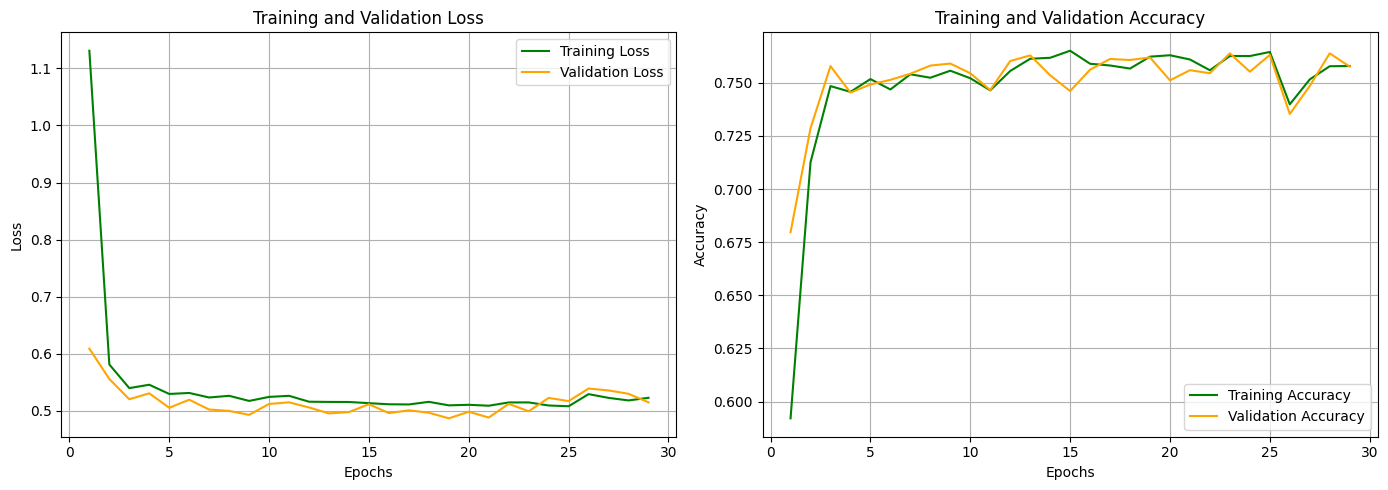

559/559 [==============================] - 1s 1ms/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1000)              27000     
                                                                 
Total params: 27000 (105.47 KB)
Trainable params: 27000 (105.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model = Sequential([
    Dense(1000, activation='relu', input_shape=(X_train.shape[1],))
])

# Define the optimizer and learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 100
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot leaning curves
plot_curves(history)

# Confusion matrix i model summary
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix1 = confusion_matrix(y_test, y_pred)
auc_roc1 = roc_auc_score(y_test, y_pred)
class_report1 = classification_report(y_test, y_pred)
model_sum_1 = model.summary()


### 5.3 Model 2 de MLP:

El segon dels nostres models l'hem fet amb dues capa amb 50 neurones:

Epoch 1/100
587/587 - 2s - loss: 0.6903 - accuracy: 0.6690 - val_loss: 0.5793 - val_accuracy: 0.6785 - 2s/epoch - 4ms/step
Epoch 2/100
587/587 - 1s - loss: 0.5465 - accuracy: 0.7464 - val_loss: 0.5114 - val_accuracy: 0.7619 - 1s/epoch - 2ms/step
Epoch 3/100
587/587 - 1s - loss: 0.5899 - accuracy: 0.7137 - val_loss: 0.5546 - val_accuracy: 0.7348 - 1s/epoch - 2ms/step
Epoch 4/100
587/587 - 2s - loss: 0.5361 - accuracy: 0.7600 - val_loss: 0.5053 - val_accuracy: 0.7562 - 2s/epoch - 4ms/step
Epoch 5/100
587/587 - 2s - loss: 0.5259 - accuracy: 0.7618 - val_loss: 0.5127 - val_accuracy: 0.7737 - 2s/epoch - 3ms/step
Epoch 6/100
587/587 - 1s - loss: 0.5470 - accuracy: 0.7371 - val_loss: 0.5196 - val_accuracy: 0.7595 - 1s/epoch - 2ms/step
Epoch 7/100
587/587 - 1s - loss: 0.5159 - accuracy: 0.7710 - val_loss: 0.4972 - val_accuracy: 0.7732 - 1s/epoch - 2ms/step
Epoch 8/100
587/587 - 1s - loss: 0.5092 - accuracy: 0.7687 - val_loss: 0.5000 - val_accuracy: 0.7698 - 1s/epoch - 2ms/step
Epoch 9/100
587/

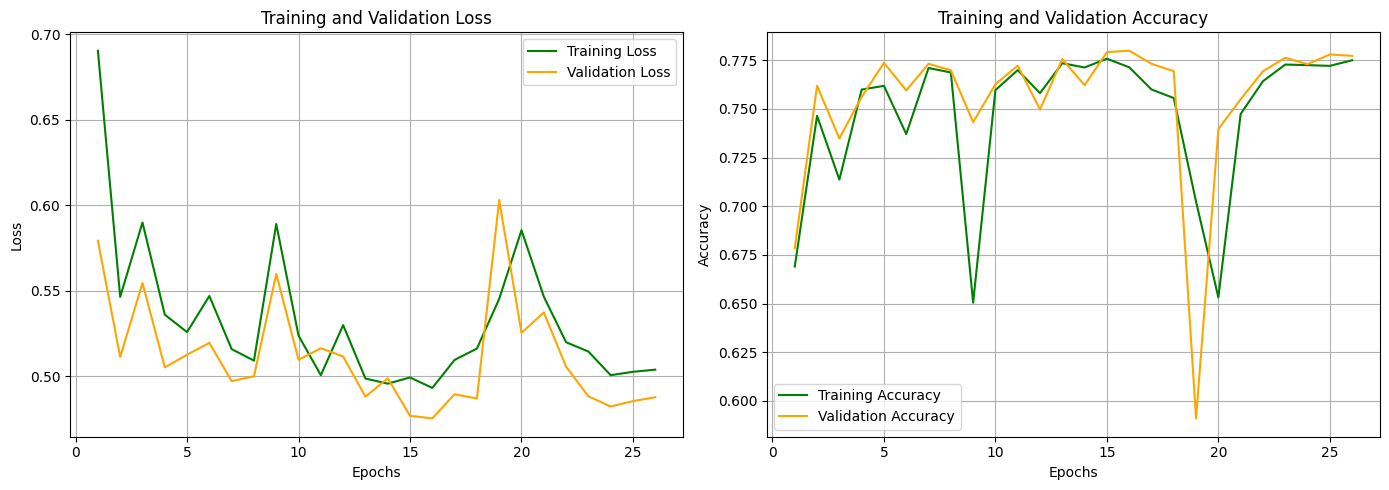

559/559 [==============================] - 1s 1ms/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 50)                1350      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
Total params: 3900 (15.23 KB)
Trainable params: 3900 (15.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model = Sequential([
    Dense(50, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(50, activation='relu')
])

# Define the optimizer and learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 100
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot leaning curves
plot_curves(history)

# Confusion matrix i model summary
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix2 = confusion_matrix(y_test, y_pred)
auc_roc2 = roc_auc_score(y_test, y_pred)
class_report2 = classification_report(y_test, y_pred)
model_sum_2 = model.summary()


### 5.4 Model 3 de MLP:

El tercer dels nostres models l'hem fet amb tres capes amb 100, 64 i 10 neurones:

Epoch 1/100
587/587 - 4s - loss: 0.5537 - accuracy: 0.7424 - val_loss: 0.4592 - val_accuracy: 0.7756 - 4s/epoch - 6ms/step
Epoch 2/100
587/587 - 1s - loss: 0.4686 - accuracy: 0.7754 - val_loss: 0.4509 - val_accuracy: 0.7821 - 1s/epoch - 3ms/step
Epoch 3/100
587/587 - 1s - loss: 0.4617 - accuracy: 0.7793 - val_loss: 0.4613 - val_accuracy: 0.7730 - 1s/epoch - 3ms/step
Epoch 4/100
587/587 - 1s - loss: 0.4573 - accuracy: 0.7825 - val_loss: 0.4451 - val_accuracy: 0.7782 - 1s/epoch - 3ms/step
Epoch 5/100
587/587 - 1s - loss: 0.4535 - accuracy: 0.7833 - val_loss: 0.4432 - val_accuracy: 0.7816 - 1s/epoch - 3ms/step
Epoch 6/100
587/587 - 2s - loss: 0.4506 - accuracy: 0.7855 - val_loss: 0.4516 - val_accuracy: 0.7789 - 2s/epoch - 3ms/step
Epoch 7/100
587/587 - 2s - loss: 0.4481 - accuracy: 0.7875 - val_loss: 0.4443 - val_accuracy: 0.7801 - 2s/epoch - 3ms/step
Epoch 8/100
587/587 - 2s - loss: 0.4467 - accuracy: 0.7878 - val_loss: 0.4415 - val_accuracy: 0.7833 - 2s/epoch - 3ms/step
Epoch 9/100
587/

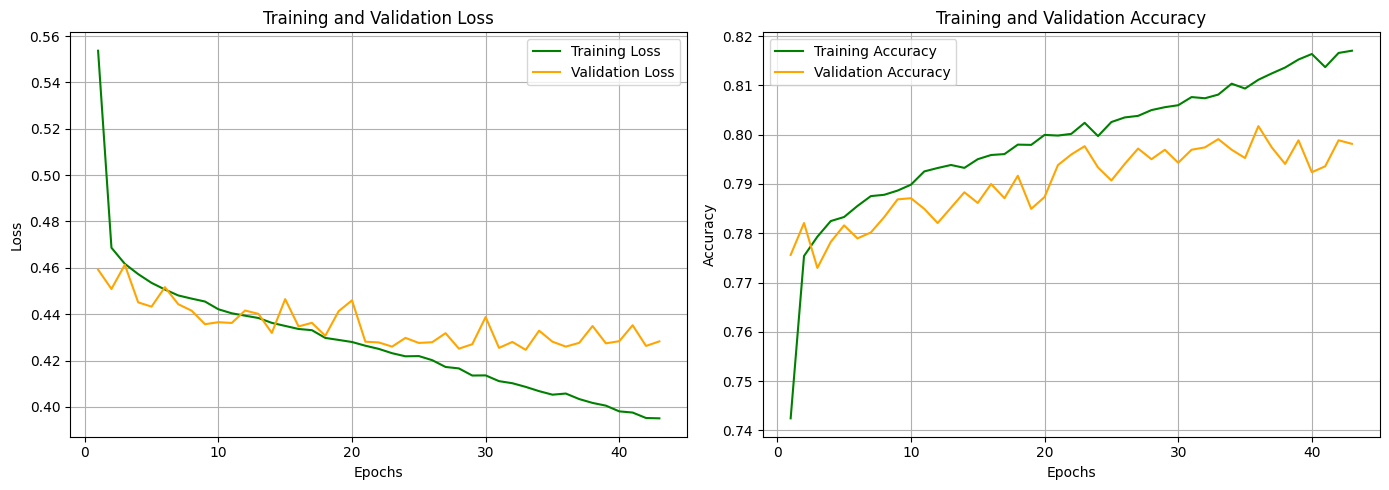

559/559 [==============================] - 1s 1ms/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               3456      
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 10)                650       
                                                                 
Total params: 12362 (48.29 KB)
Trainable params: 12362 (48.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Definim l'optimitzador i la taxa d'aprenentatge
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilem el model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenem el model
num_epochs = 100
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot leaning curves
plot_curves(history)

# Confusion matrix i model summary
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix3 = confusion_matrix(y_test, y_pred)
auc_roc3 = roc_auc_score(y_test, y_pred)
class_report3 = classification_report(y_test, y_pred)
model_sum_3 = model.summary()



### 5.5 Model 4 de MLP:

L'últim dels nostres models l'hem fet amb una sola capa de 10 neurones:

Epoch 1/100
587/587 - 2s - loss: 1.0788 - accuracy: 0.5442 - val_loss: 0.7244 - val_accuracy: 0.5584 - 2s/epoch - 3ms/step
Epoch 2/100
587/587 - 1s - loss: 0.6861 - accuracy: 0.5678 - val_loss: 0.6834 - val_accuracy: 0.5653 - 1s/epoch - 2ms/step
Epoch 3/100
587/587 - 2s - loss: 0.6609 - accuracy: 0.5839 - val_loss: 0.6527 - val_accuracy: 0.5802 - 2s/epoch - 3ms/step
Epoch 4/100
587/587 - 2s - loss: 0.6382 - accuracy: 0.6024 - val_loss: 0.6399 - val_accuracy: 0.6147 - 2s/epoch - 3ms/step
Epoch 5/100
587/587 - 1s - loss: 0.6236 - accuracy: 0.6167 - val_loss: 0.6223 - val_accuracy: 0.5972 - 1s/epoch - 2ms/step
Epoch 6/100
587/587 - 1s - loss: 0.6146 - accuracy: 0.6152 - val_loss: 0.6177 - val_accuracy: 0.6118 - 1s/epoch - 2ms/step
Epoch 7/100
587/587 - 1s - loss: 0.6137 - accuracy: 0.6294 - val_loss: 0.6171 - val_accuracy: 0.6154 - 1s/epoch - 2ms/step
Epoch 8/100
587/587 - 1s - loss: 0.6106 - accuracy: 0.6400 - val_loss: 0.6163 - val_accuracy: 0.6349 - 1s/epoch - 2ms/step
Epoch 9/100
587/

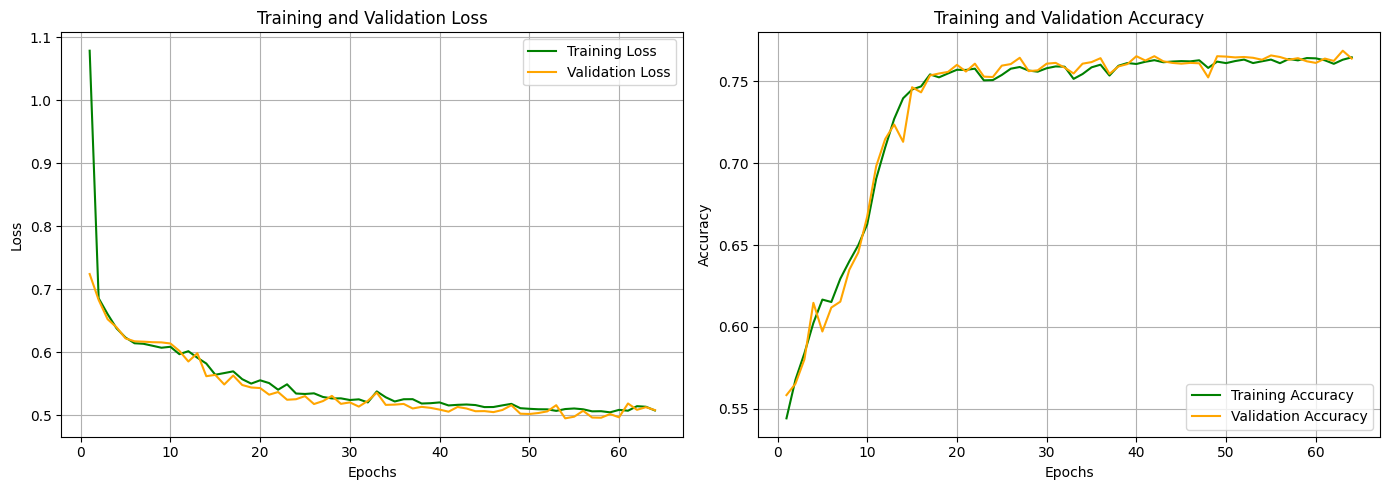

559/559 [==============================] - 1s 2ms/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 10)                270       
                                                                 
Total params: 270 (1.05 KB)
Trainable params: 270 (1.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model = Sequential([
    Dense(10, activation='relu', input_shape=(X_train.shape[1],))
])

# Define the optimizer and learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 100
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot leaning curves
plot_curves(history)

# Confusion matrix i model summary
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix4 = confusion_matrix(y_test, y_pred)
auc_roc4 = roc_auc_score(y_test, y_pred)
class_report4 = classification_report(y_test, y_pred)
model_sum_4 = model.summary()


### 5.6. Matriu de confusió pels quatre models anteriors:

In [ ]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Confusion matrix model 1:


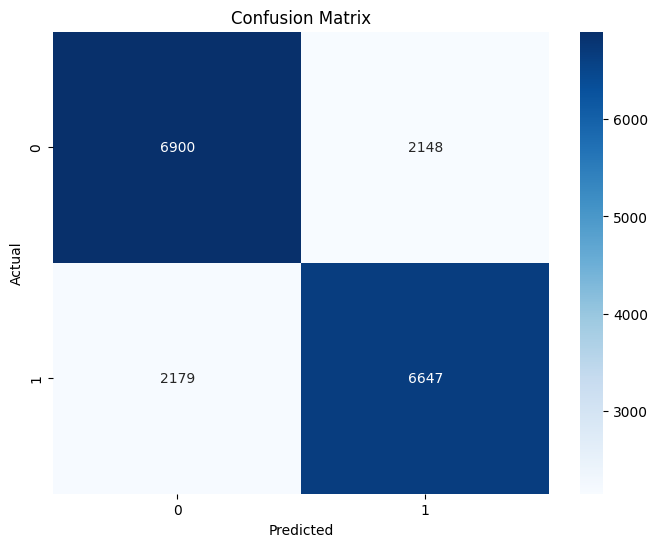

AUC-ROC Score 1: 0.7578576318701497
Classification Report 1:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      9048
           1       0.76      0.75      0.75      8826

    accuracy                           0.76     17874
   macro avg       0.76      0.76      0.76     17874
weighted avg       0.76      0.76      0.76     17874

Confusion matrix model 2:


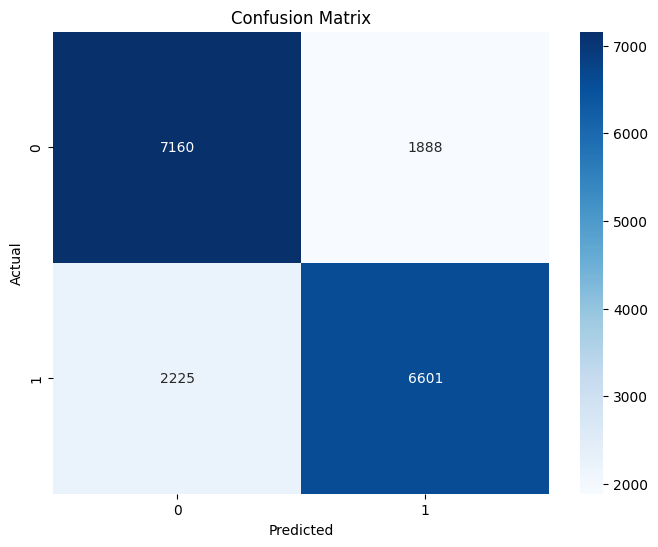

AUC-ROC Score 2: 0.7696195109577982
Classification Report 2:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      9048
           1       0.78      0.75      0.76      8826

    accuracy                           0.77     17874
   macro avg       0.77      0.77      0.77     17874
weighted avg       0.77      0.77      0.77     17874

Confusion matrix model 3:


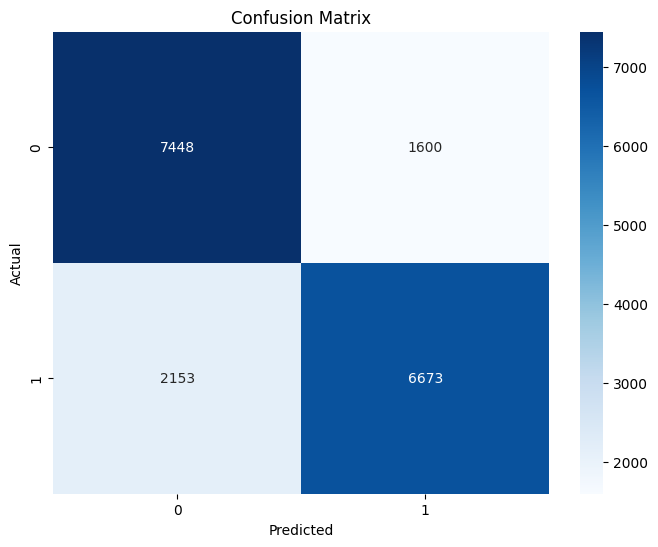

AUC-ROC Score 3: 0.789613488240976
Classification Report 3:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      9048
           1       0.81      0.76      0.78      8826

    accuracy                           0.79     17874
   macro avg       0.79      0.79      0.79     17874
weighted avg       0.79      0.79      0.79     17874

Confusion matrix model 4:


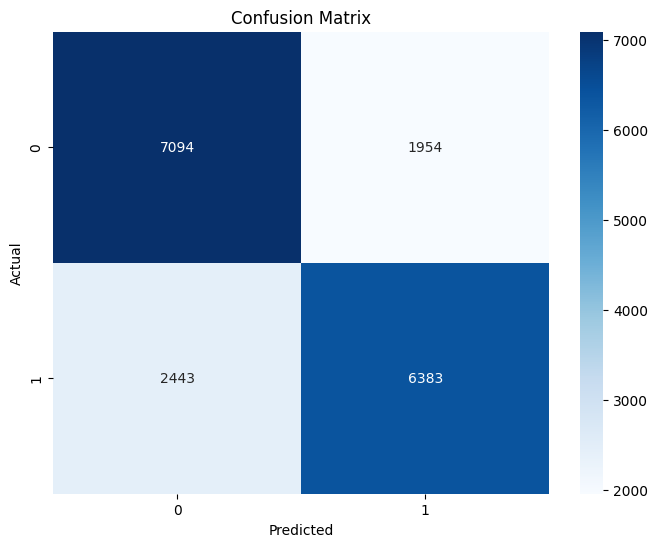

AUC-ROC Score 4: 0.7536224207354567
Classification Report 4:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      9048
           1       0.77      0.72      0.74      8826

    accuracy                           0.75     17874
   macro avg       0.75      0.75      0.75     17874
weighted avg       0.75      0.75      0.75     17874

Confusion matrix model 1:


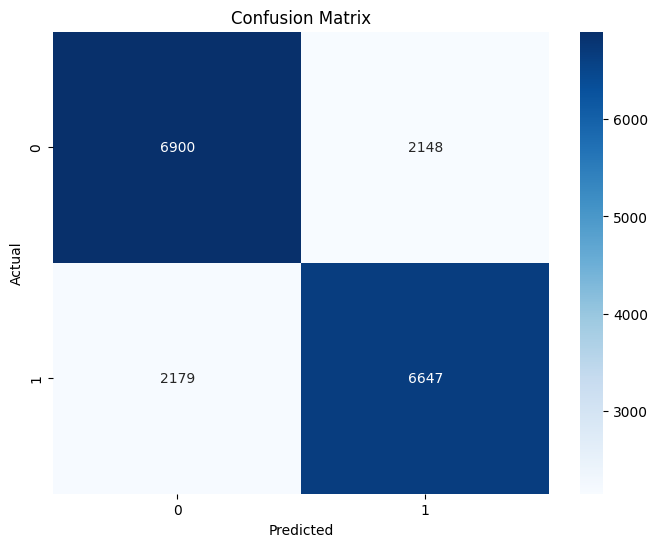

AUC-ROC Score: 0.7578576318701497


In [ ]:
print('Confusion matrix model 1:')
plot_confusion_matrix(conf_matrix1)
print("AUC-ROC Score 1:", auc_roc1)
print("Classification Report 1:")
print(class_report1)

print('Confusion matrix model 2:')
plot_confusion_matrix(conf_matrix2)
print("AUC-ROC Score 2:", auc_roc2)
print("Classification Report 2:")
print(class_report2)

print('Confusion matrix model 3:')
plot_confusion_matrix(conf_matrix3)
print("AUC-ROC Score 3:", auc_roc3)
print("Classification Report 3:")
print(class_report3)

print('Confusion matrix model 4:')
plot_confusion_matrix(conf_matrix4)
print("AUC-ROC Score 4:", auc_roc4)
print("Classification Report 4:")
print(class_report4)

print('Confusion matrix model 1:')
plot_confusion_matrix(conf_matrix1)
print("AUC-ROC Score:", auc_roc1)